In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c sberbank-russian-housing-market

  0% 0.00/18.6k [00:00<?, ?B/s]
100% 18.6k/18.6k [00:00<00:00, 36.2MB/s]
 59% 10.0M/17.1M [00:00<00:00, 103MB/s]
100% 17.1M/17.1M [00:00<00:00, 109MB/s]
  0% 0.00/4.46M [00:00<?, ?B/s]
100% 4.46M/4.46M [00:00<00:00, 133MB/s]
  0% 0.00/25.4k [00:00<?, ?B/s]
100% 25.4k/25.4k [00:00<00:00, 26.9MB/s]
  0% 0.00/66.5k [00:00<?, ?B/s]
100% 66.5k/66.5k [00:00<00:00, 68.3MB/s]


# Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import warnings
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
warnings.filterwarnings(action='ignore')

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb

In [ ]:
train_df = pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')


In [ ]:
print("train shape: ", train_df.shape)
print("test shape: ",test_df.shape)

train shape:  (30471, 292)
test shape:  (7662, 291)


In [ ]:
train_df.head()


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


# Анализ данных

Посмотрим на целевую переменную и ее распеделение.

In [ ]:
train_df['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

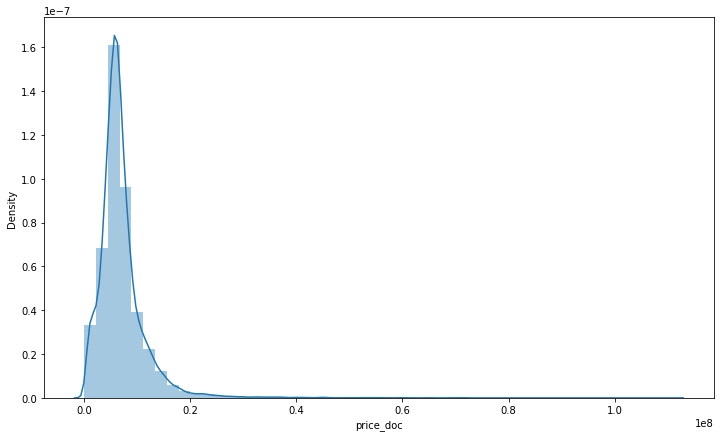

In [ ]:
plt.subplots(figsize=(12, 7))
sns.distplot(train_df['price_doc'])
plt.show()

По графику видно, что целевая переменная ассиметрична влево.

Прологарифмируем целевую переменную для приближения распределения к нормальному.

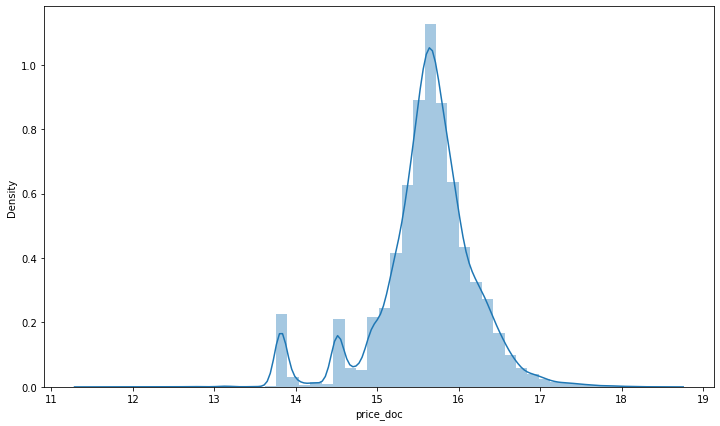

In [ ]:
train_df['price_doc'] = np.log1p(train_df['price_doc'])

plt.subplots(figsize=(12, 7))
sns.distplot(train_df['price_doc'])
plt.show()

После логарифмирования график распределения целевой переменной выглядит лучше.

Проверим есть ли пропущенные значения в целевой переменной.

In [ ]:
train_df.price_doc.isnull().sum()

0

Пропущенных значений нет. 

Рассмотрим какие типы данных у остальных переменных датасета.

In [ ]:
train_df.dtypes

id                      int64
timestamp              object
full_sq                 int64
life_sq               float64
floor                 float64
                       ...   
mosque_count_5000       int64
leisure_count_5000      int64
sport_count_5000        int64
market_count_5000       int64
price_doc               int64
Length: 292, dtype: object

Посмотрим в каких переменных больше всего пропусков.

In [ ]:
missing = train_df.columns[train_df.isnull().any()].tolist()

pd.isnull(train_df[missing]).sum().sort_values(ascending=False) / len (train_df)

hospital_beds_raion                      0.473926
build_year                               0.446490
state                                    0.444980
cafe_sum_500_max_price_avg               0.435857
cafe_sum_500_min_price_avg               0.435857
cafe_avg_price_500                       0.435857
max_floor                                0.314135
material                                 0.314135
num_room                                 0.314135
kitch_sq                                 0.314135
preschool_quota                          0.219487
school_quota                             0.219389
cafe_avg_price_1000                      0.214105
cafe_sum_1000_max_price_avg              0.214105
cafe_sum_1000_min_price_avg              0.214105
life_sq                                  0.209478
raion_build_count_with_builddate_info    0.163795
build_count_after_1995                   0.163795
build_count_1946-1970                    0.163795
build_count_1921-1945                    0.163795


Рассмотрим зависимость целевой переменной от других признаков.

In [ ]:
train_df['year_month'] = train_df['timestamp'].apply(lambda x: x[:4] + x[5:7]).astype(int)
train_df['year'] = train_df['timestamp'].apply(lambda x: x[:4]).astype(int)
train_df['month'] = train_df['timestamp'].apply(lambda x: x[5:7]).astype(int)


test_df['year_month'] = test_df['timestamp'].apply(lambda x: x[:4] + x[5:7]).astype(int)
test_df['year'] = test_df['timestamp'].apply(lambda x: x[:4]).astype(int)
test_df['month'] = test_df['timestamp'].apply(lambda x: x[5:7]).astype(int)

train_df.drop('timestamp', axis=1, inplace=True)
test_df.drop('timestamp', axis=1, inplace=True)

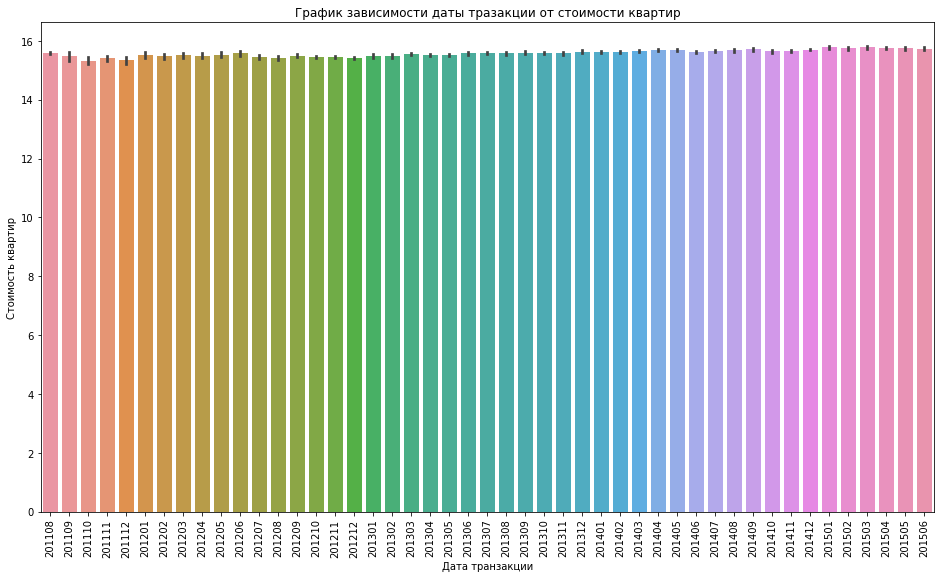

In [ ]:
plt.figure(figsize=(16,9))
sns.barplot(x='year_month', y='price_doc', data=train_df)
plt.title("График зависимости даты тразакции от стоимости квартир")
plt.xlabel("Дата транзакции")
plt.ylabel("Стоимость квартир")
plt.xticks(rotation='vertical')
plt.show()

По графику прослеживается тенденция роста стоимости квартир с увеличением даты.

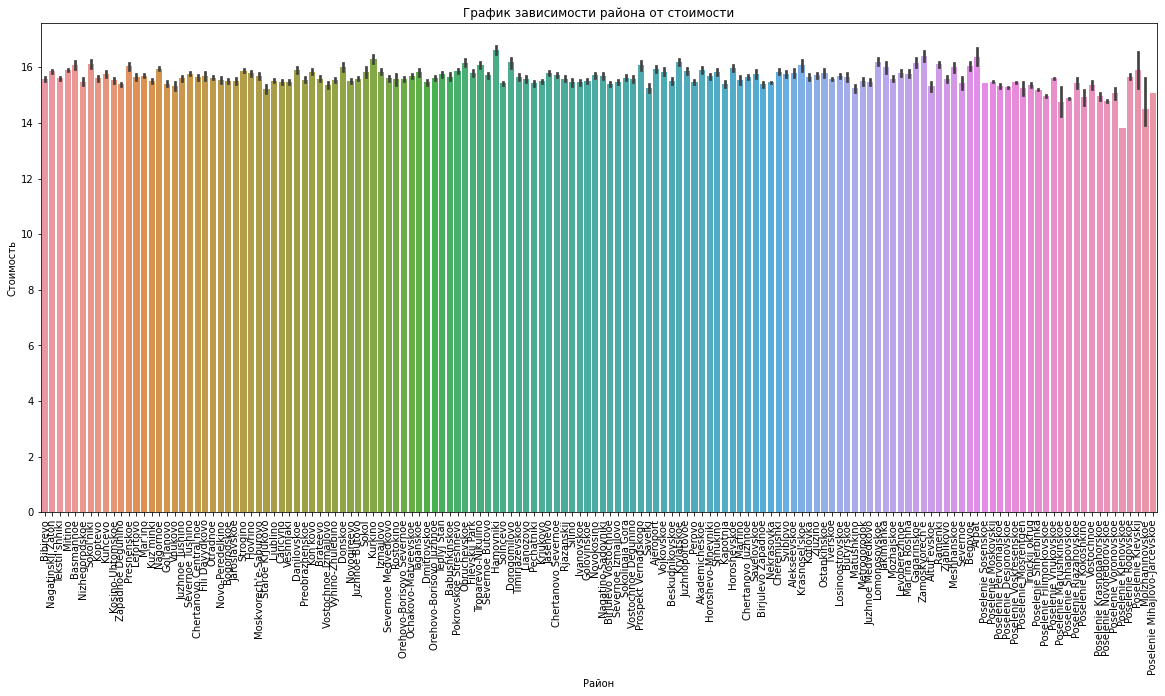

In [ ]:
plt.figure(figsize=(20,9))
sns.barplot(x='sub_area', y='price_doc', data=train_df)
plt.title("График зависимости района от стоимости")
plt.xlabel("Район")
plt.ylabel("Стоимость")
plt.xticks(rotation='vertical')
plt.show()

По графику видно, что самая высокая цена квартир в центре - районы Хамовники, Арбат, Замоскворечье, что в принципе логично.

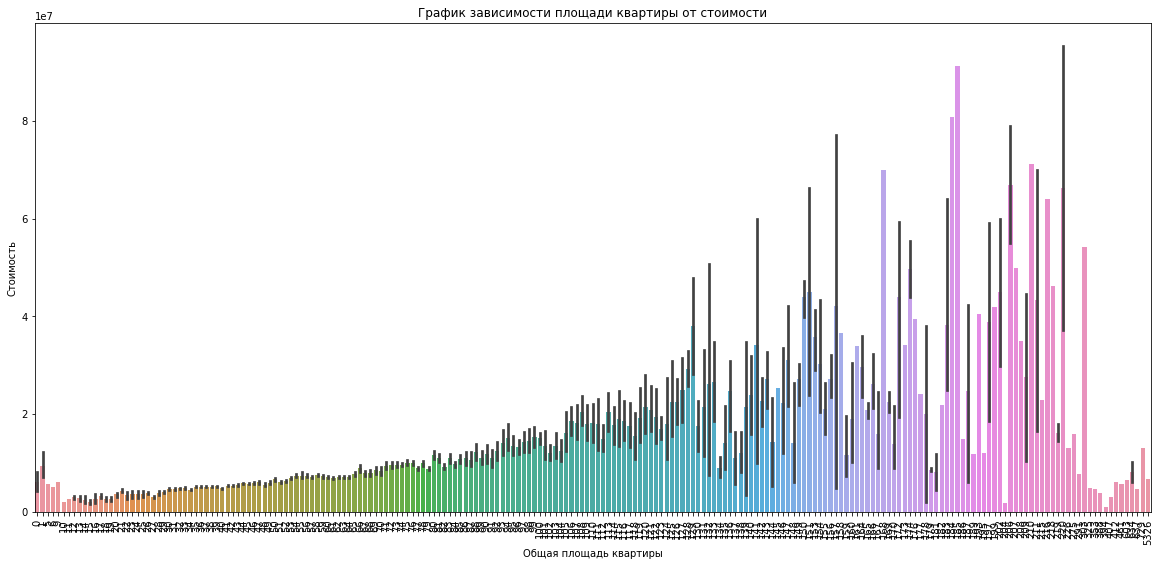

In [ ]:
plt.figure(figsize=(20,9))
sns.barplot(x='full_sq', y='price_doc', data=train_df)
plt.title("График зависимости площади квартиры от стоимости")
plt.xlabel("Общая площадь квартиры")
plt.ylabel("Стоимость")
plt.xticks(rotation='vertical')
plt.show()

На данном графике также наблюдается рост стоимости с увеличением площади квартиры.

Посмотрим на корреляцию между целевой переменной и другими признаками. Рассмотрим 10 признаков в набольшей корреляцией.

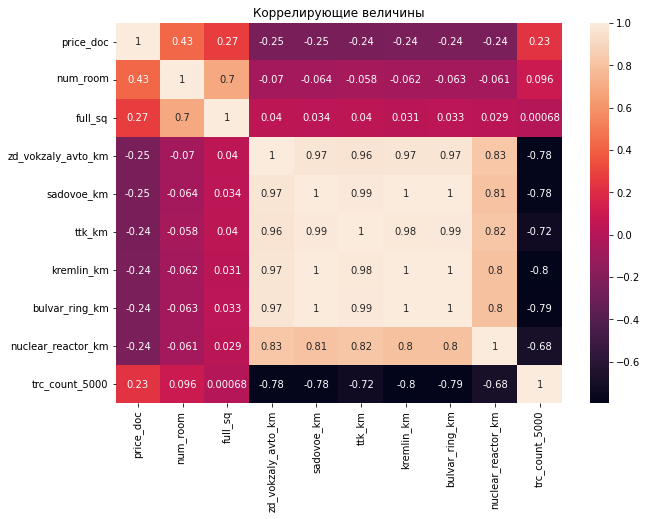

In [ ]:
f, ax = plt.subplots(figsize=(10, 7))
highcorr_vars = (abs(train_df.corr().price_doc).sort_values(ascending=False)[:10]).index
sns.heatmap(train_df[highcorr_vars].corr(), annot=True)
plt.title('Коррелирующие величины')
plt.show()

По графику видно, что признаки num_room (количество комнат)  и full_sq (общая площадь) хорошо коррелируют с остальными.

# Обработка данных и подготовка данных

Откорретируем значения в некоторых колонках

In [ ]:
bad_index = train_df[train_df.life_sq > train_df.full_sq].index
train_df.loc[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test_df.loc[equal_index, "life_sq"] = test_df.loc[equal_index, "full_sq"]
bad_index = test_df[test_df.life_sq > test_df.full_sq].index
test_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = train_df[train_df.life_sq < 5].index
train_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = test_df[test_df.life_sq < 5].index
test_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = train_df[train_df.full_sq < 5].index
train_df.loc[bad_index, "full_sq"] = np.NaN
bad_index = test_df[test_df.full_sq < 5].index
test_df.loc[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train_df.loc[kitch_is_build_year, "build_year"] = train_df.loc[kitch_is_build_year, "kitch_sq"]
bad_index = train_df[train_df.kitch_sq >= train_df.life_sq].index
train_df.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test_df[test_df.kitch_sq >= test_df.life_sq].index
test_df.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = train_df[(train_df.kitch_sq == 0).values + (train_df.kitch_sq == 1).values].index
train_df.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test_df[(test_df.kitch_sq == 0).values + (test_df.kitch_sq == 1).values].index
test_df.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = train_df[(train_df.full_sq > 210) & (train_df.life_sq / train_df.full_sq < 0.3)].index
train_df.loc[bad_index, "full_sq"] = np.NaN
bad_index = test_df[(test_df.full_sq > 150) & (test_df.life_sq / test_df.full_sq < 0.3)].index
test_df.loc[bad_index, "full_sq"] = np.NaN
bad_index = train_df[train_df.life_sq > 300].index
train_df.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test_df[test_df.life_sq > 200].index
test_df.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN
train_df.product_type.value_counts(normalize= True)
test_df.product_type.value_counts(normalize= True)
bad_index = train_df[train_df.build_year < 1500].index
train_df.loc[bad_index, "build_year"] = np.NaN
bad_index = test_df[test_df.build_year < 1500].index
test_df.loc[bad_index, "build_year"] = np.NaN
bad_index = train_df[train_df.num_room == 0].index
train_df.loc[bad_index, "num_room"] = np.NaN
bad_index = test_df[test_df.num_room == 0].index
test_df.loc[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train_df.loc[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test_df.loc[bad_index, "num_room"] = np.NaN
bad_index = train_df[(train_df.floor == 0).values * (train_df.max_floor == 0).values].index
train_df.loc[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train_df[train_df.floor == 0].index
train_df.loc[bad_index, "floor"] = np.NaN
bad_index = train_df[train_df.max_floor == 0].index
train_df.loc[bad_index, "max_floor"] = np.NaN
bad_index = test_df[test_df.max_floor == 0].index
test_df.loc[bad_index, "max_floor"] = np.NaN
bad_index = train_df[train_df.floor > train_df.max_floor].index
train_df.loc[bad_index, "max_floor"] = np.NaN
bad_index = test_df[test_df.floor > test_df.max_floor].index
test_df.loc[bad_index, "max_floor"] = np.NaN
train_df.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train_df.loc[bad_index, "floor"] = np.NaN


В категориальных признаках пропущенные значения заменим на пустую сторку.

In [ ]:
train_df.loc[:,list(train_df.dtypes[train_df.dtypes == "object"].index)].fillna("")

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
1,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
4,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,Investment,Otradnoe,no,no,yes,no,yes,no,no,no,no,no,no,no,good
30467,Investment,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor
30468,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data
30469,Investment,Obruchevskoe,no,no,no,no,yes,no,no,no,no,no,no,no,satisfactory


In [ ]:
test_df.loc[:,list(test_df.dtypes[test_df.dtypes == "object"].index) ].fillna("")


,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,Investment,Juzhnoe Butovo,no,no,no,no,no,no,no,no,no,no,no,no,satisfactory
1,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data
2,Investment,Perovo,no,yes,no,yes,yes,no,no,no,no,no,no,no,poor
3,OwnerOccupier,Poselenie Voskresenskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data
4,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,Investment,Kon'kovo,no,no,no,no,yes,no,no,no,no,no,no,no,satisfactory
7658,OwnerOccupier,Poselenie Desjonovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data
7659,OwnerOccupier,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,excellent
7660,Investment,Orehovo-Borisovo Juzhnoe,no,no,no,no,no,no,yes,no,no,no,no,no,poor


Для вещественных данных заменим на значения медианы и моды

In [ ]:
cols_mode = ['floor',
 'product_type', 
 'build_year',                 
 'max_floor',
 'material',
 'num_room',
 'state',
 'preschool_quota',
 'school_quota',
 'hospital_beds_raion',
 'raion_build_count_with_material_info',
 'raion_build_count_with_builddate_info',
 'ID_railroad_station_walk',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'green_part_2000']

cols_mean = ['life_sq','full_sq',
 'kitch_sq',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_avg_price_5000']

In [ ]:
for col in cols_mode:
    train_df[col].fillna(train_df[col].mode().iloc[0],inplace=True)
    test_df[col].fillna(test_df[col].mode().iloc[0],inplace=True)
    
for col in cols_mean:
    train_df[col].fillna(train_df[col].mean(),inplace=True)
    test_df[col].fillna(test_df[col].mean(),inplace=True)

In [ ]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


Теперь пропущенных значений нет.

# Обучение

Обучим модель с помощью CatBoostRegressor

In [ ]:
train_id = train_df.id
test_id = test_df.id
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

In [ ]:
cat_features = list(all_data.dtypes[all_data.dtypes == "object"].index)

In [ ]:
y =np.log1p(train_df['price_doc'])
X = train_df.drop(['price_doc'], axis=1)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (30471, 292)
y shape: (30471,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
cat = CatBoostRegressor()

In [ ]:
model=cat.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=(X_valid, y_valid), 
              use_best_model=True)
             

Learning rate set to 0.084072
0:	learn: 0.5898893	test: 0.5880150	best: 0.5880150 (0)	total: 105ms	remaining: 1m 45s
1:	learn: 0.5771548	test: 0.5757573	best: 0.5757573 (1)	total: 189ms	remaining: 1m 34s
2:	learn: 0.5656269	test: 0.5642904	best: 0.5642904 (2)	total: 277ms	remaining: 1m 31s
3:	learn: 0.5555978	test: 0.5542406	best: 0.5542406 (3)	total: 368ms	remaining: 1m 31s
4:	learn: 0.5465962	test: 0.5455210	best: 0.5455210 (4)	total: 462ms	remaining: 1m 31s
5:	learn: 0.5383213	test: 0.5374858	best: 0.5374858 (5)	total: 557ms	remaining: 1m 32s
6:	learn: 0.5314595	test: 0.5306711	best: 0.5306711 (6)	total: 645ms	remaining: 1m 31s
7:	learn: 0.5253451	test: 0.5245566	best: 0.5245566 (7)	total: 729ms	remaining: 1m 30s
8:	learn: 0.5194619	test: 0.5188180	best: 0.5188180 (8)	total: 823ms	remaining: 1m 30s
9:	learn: 0.5143155	test: 0.5136886	best: 0.5136886 (9)	total: 919ms	remaining: 1m 31s
10:	learn: 0.5099026	test: 0.5094133	best: 0.5094133 (10)	total: 1.01s	remaining: 1m 31s
11:	learn: 

In [ ]:
cb_train_pred = model.predict(X_train)
cb_pred = np.expm1(model.predict(X_valid))


In [ ]:
np.sqrt(mean_squared_error(y_train,cb_train_pred))

0.40719064931850457

# Подготовка данных для Kaggle

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['price_doc'] = cb_pred
sub.to_csv('submission_2022.csv',index=False)

# Результат на Kaggle

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()


Saving Kg.jpg to Kg.jpg


In [ ]:
im = Image.open(BytesIO(uploaded['Kg.jpg']))

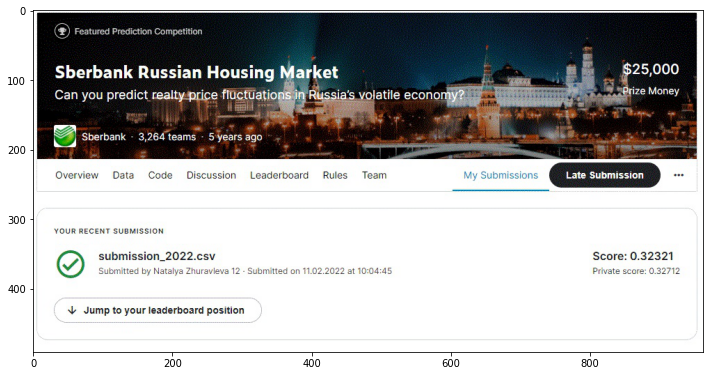

In [ ]:
plt.subplots(figsize=(12, 7))
plt.imshow(im)
plt.show()